# Self-Organized Criticality in Matching Games

### Ben Morris

Are games like Candy Crush and Bejeweled examples of Self-Organized Criticality?

## Abstract

Bejeweled and Candy Crush, along with many other mobile games, are all takes on the general gameplay that I will refer to as Matching Games. Given the grid-like nature and potential for long chains of matches, matching games may have the potential to be examples of Self-Organized Criticality (SOC) like that explored in <whoever's> Sandpile Model. <insert link>

## Matching Games

 Matching Games all work in mostly the same way. Each has a grid of different colored items, and allow the player to swap two adjacent ones to make a "match" - at least three in a row. The matched items then disappear, and the ones above fall to replace those gone, with random items coming from the top to fill in any remaining space. This can often lead to chains of matching, where the newly fallen items will match with those around them, causing more to fall.

I will represent the grid as a numpy array containing integers from 0-n (inclusive). Each number will represent a different type of item in the grid, or color.

In [1]:
import numpy as np

# Starting with a 10x10 grid and 4 colors
num_colors = 4
grid = np.random.randint(0, num_colors, (10, 10))
grid

array([[2, 0, 1, 2, 3, 2, 3, 1, 2, 0],
       [0, 3, 1, 3, 3, 2, 0, 0, 3, 3],
       [2, 3, 3, 0, 1, 1, 3, 1, 2, 2],
       [3, 3, 3, 3, 2, 1, 2, 2, 0, 1],
       [1, 1, 1, 0, 0, 2, 1, 2, 2, 3],
       [3, 3, 0, 3, 0, 0, 0, 0, 3, 1],
       [1, 1, 0, 1, 0, 3, 3, 0, 1, 0],
       [2, 3, 3, 3, 3, 3, 3, 2, 0, 2],
       [1, 2, 1, 0, 0, 2, 3, 1, 2, 2],
       [2, 0, 2, 2, 0, 3, 1, 3, 3, 0]])

To find matches, I use scipy's `correlate2d` along with some manipulation in base `num_colors`. For each cell in the grid, I need to detect matches on the left, right, and on both sides. Since the code needs to detect matches both two to the left and two to the right, I will use a kernel that is 5 long, where each value is a power of `num_colors`.

In [2]:
from scipy.signal import correlate2d

horz_kernel = np.array([num_colors ** i for i in range(5)]).reshape(1, -1)
corr = correlate2d(grid, horz_kernel, mode='same')
corr

array([[ 288,  584,  914,  740,  953,  494,  635,  158,   39,    9],
       [ 448,  880,  988,  759,  189,   47,  779,  962,  240,   60],
       [ 992,  248,  318,  335,  851,  468,  629,  669,  167,   41],
       [1008, 1020,  767,  447,  623,  667,  166,  297,   74,   18],
       [ 336,   84,   21,  517,  385,  608,  664,  934,  233,   58],
       [ 240,  828,  207,   51,   12,    3,  768,  448,  112,   28],
       [  80,  276,   69,  785,  964,  241,  316,   79,   19,    4],
       [ 992, 1016, 1022, 1023, 1023,  767,  191,  559,  139,   34],
       [ 400,  100,   25,  518,  897,  480,  632,  670,  167,   41],
       [ 544,  648,  162,  808,  458,  882,  988,  247,   61,   15]])

While the numbers may seem random, convert them to base 4 and they will match the local neighborhood given by grid.

Now, I need to extract matches from these numbers. In base 4, possible matches look like this:

* __111
* \_111_
* 111__

These can be extracted with basic floor division and modulus operations as shown below. Since the 1 can actually be any number up to `num_colors-1`, the code must check if the resultant values are multiples of 111 (base 4)

In [3]:
# 10, 100, 1000, and 111 in base (num_colors)
c10 = num_colors
c100 = num_colors ** 2
c1000 = num_colors ** 3
c111 = c100 + c10 + 1

left3 = (corr // c100) % c111 == 0
mid3 = ((corr // c10) % c1000) % c111 == 0
right3 = (corr % c1000) % c111 == 0

horz_matches = left3 | mid3 | right3
horz_matches

array([[False, False, False, False, False, False, False, False, False,
         True],
       [ True, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [ True,  True,  True,  True, False, False, False, False, False,
        False],
       [ True,  True,  True, False, False, False, False, False, False,
        False],
       [False, False, False, False,  True,  True,  True,  True, False,
        False],
       [False, False, False, False, False, False, False, False, False,
         True],
       [False,  True,  True,  True,  True,  True,  True, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
         True]])

This code is encapsulated in `get_match_array`. This is called twice in `get_matches`; once for horizontal, and once for vertical.

In [4]:
def get_match_array(grid, kernel):
    corr = correlate2d(grid, kernel, mode='same')
    n = np.max(grid) + 1
    c10 = n
    c100 = n ** 2
    c1000 = n ** 3
    c111 = c100 + c10 + 1

    left3 = (corr // c100) % c111 == 0
    mid3 = ((corr // c10) % c1000) % c111 == 0
    right3 = (corr % c1000) % c111 == 0
    return left3 | mid3 | right3

def get_matches(grid, num_colors):
    horz_kernel = np.array([num_colors ** i for i in range(5)]).reshape(1, -1)
    return get_match_array(grid, horz_kernel) | get_match_array(grid, horz_kernel.T)

In [5]:
matches = get_matches(grid, num_colors)
matches

array([[False,  True, False, False, False, False, False, False, False,
         True],
       [ True,  True, False, False, False, False, False, False, False,
        False],
       [False,  True, False, False, False, False, False, False, False,
        False],
       [ True,  True,  True,  True, False, False, False, False, False,
        False],
       [ True,  True,  True, False,  True, False, False, False, False,
        False],
       [False, False, False, False,  True,  True,  True,  True, False,
        False],
       [False, False, False, False,  True, False,  True, False, False,
         True],
       [False,  True,  True,  True,  True,  True,  True, False, False,
        False],
       [False, False, False, False,  True, False,  True, False, False,
        False],
       [False,  True, False, False,  True, False, False, False, False,
         True]])

`drop_items` will use remove the matches and drop the remaining items down, giving any empty cells a value of -1.

In [6]:
def drop_items(grid, matches):
    grid[matches] = -2
    for j in range(grid.shape[1]):
        for i in range(grid.shape[0] - 1, -1, -1):
            while grid[i][j] == -2:
                grid[1:i+1, j] = grid[:i, j]
                grid[0, j] = -1

In [7]:
drop_items(grid, matches)
grid

array([[-1, -1, -1, -1, -1, -1, -1, -1,  2, -1],
       [-1, -1, -1, -1, -1, -1, -1,  1,  3, -1],
       [-1, -1, -1,  2, -1,  2, -1,  0,  2, -1],
       [ 2, -1,  1,  3, -1,  2, -1,  1,  0,  3],
       [ 2, -1,  1,  0, -1,  1,  3,  2,  2,  2],
       [ 3, -1,  3,  0, -1,  1,  0,  2,  3,  1],
       [ 1, -1,  0,  3,  3,  2,  3,  0,  1,  3],
       [ 2,  3,  0,  1,  3,  3,  2,  2,  0,  1],
       [ 1,  1,  1,  0,  1,  2,  1,  1,  2,  2],
       [ 2,  2,  2,  2,  2,  3,  1,  3,  3,  2]])

Finally, `fill_empty` will fill the remaining empty cells with random colors.

In [8]:
def fill_empty(grid, num_colors):
    empty = grid == -1
    grid[empty] = np.random.randint(0, num_colors, grid.shape)[empty]

In [9]:
fill_empty(grid, num_colors)
grid

array([[1, 3, 0, 2, 2, 3, 1, 3, 2, 0],
       [1, 2, 2, 2, 2, 3, 2, 1, 3, 0],
       [3, 3, 3, 2, 0, 2, 2, 0, 2, 3],
       [2, 3, 1, 3, 1, 2, 2, 1, 0, 3],
       [2, 2, 1, 0, 0, 1, 3, 2, 2, 2],
       [3, 3, 3, 0, 2, 1, 0, 2, 3, 1],
       [1, 0, 0, 3, 3, 2, 3, 0, 1, 3],
       [2, 3, 0, 1, 3, 3, 2, 2, 0, 1],
       [1, 1, 1, 0, 1, 2, 1, 1, 2, 2],
       [2, 2, 2, 2, 2, 3, 1, 3, 3, 2]])

Finally, `step` will run all of this code until the grid reaches an equilibrium point where no new matches are made.

In [10]:
def step(grid, num_colors):
    while True:
        matches = get_matches(grid, num_colors)
        if np.sum(matches) == 0:
            return
        drop_items(grid, matches)
        fill_empty(grid, num_colors)

In [11]:
step(grid, num_colors)
grid

array([[3, 2, 1, 1, 3, 2, 2, 3, 2, 3],
       [2, 3, 2, 3, 1, 1, 2, 1, 1, 2],
       [1, 2, 3, 0, 3, 2, 3, 3, 2, 3],
       [2, 0, 0, 3, 2, 1, 1, 3, 0, 1],
       [2, 3, 2, 0, 3, 0, 2, 1, 3, 2],
       [1, 1, 2, 3, 1, 0, 1, 0, 3, 1],
       [2, 0, 3, 3, 0, 3, 3, 1, 1, 3],
       [2, 2, 0, 1, 0, 3, 0, 2, 0, 1],
       [1, 0, 0, 3, 2, 2, 3, 0, 2, 2],
       [2, 3, 3, 1, 3, 2, 1, 3, 3, 2]])

The following will show that there are no matches remaining in the grid,

In [12]:
assert np.sum(get_matches(grid, num_colors)) == 0

For simplicity, this code, along with any tracking of data, is encapsulated in `model.MatchingModel`.

In [13]:
from src.model import MatchingModel

model = MatchingModel(10, colors=4)
model.setup()
assert np.sum(model.get_matches()) == 0
model.grid

array([[3, 3, 1, 2, 3, 1, 3, 1, 3, 1],
       [2, 3, 1, 3, 2, 0, 3, 1, 3, 2],
       [1, 1, 3, 3, 0, 1, 2, 0, 1, 1],
       [2, 2, 1, 2, 2, 3, 1, 2, 3, 3],
       [1, 3, 0, 1, 3, 3, 1, 1, 2, 1],
       [3, 2, 0, 0, 3, 2, 3, 3, 0, 2],
       [2, 2, 1, 3, 2, 0, 2, 2, 3, 1],
       [2, 1, 3, 1, 3, 3, 0, 2, 3, 3],
       [3, 0, 2, 2, 0, 2, 2, 1, 2, 1],
       [1, 2, 3, 2, 1, 1, 2, 3, 1, 1]])

## Self-Organized Criticality

Self-Organized Criticality, or SOC, is a solution to a mystery of nature - why do systems, both natural and engineered, reach critical states? Critical states are defined by:
1. Pink Noise. Pink noise is a signal whose [power spectrum frequency](https://en.wikipedia.org/wiki/Spectral_density#Power_spectral_density) is proprtional to $\frac{1}{f^{\alpha}}$, where $0 < \alpha < 2$, and preferably close to 1.
2. Long-tailed distributions - distributions which are large close to x=0 and lower the bigger x gets, asymptoting at 0. $x^-1$ is an example of a long-tailed distribution.
3. Fractals. Fractals are shapes that are between dimensions - in this case, between 1D and 2D. They can be detected when a 1-dimensional value doubles, and some other value more than doubles but less than quadruples as a result.

By their nature, critical states are unstable, so we would not expect to see them often. Yet we do. The first explanation for this was _____'s Sandpile Model, which exhibited all of these characteristics with very little external input.

To assess the presence of SOC, there needs to be some external input. To implement this, I define a `RandomController` (see `src.controller`), which randomly chooses a cell and switches it with a random adjacent cell:
```python
index = tuple(np.random.randint(0, grid.shape))
direcs = [(-1, 0), (1, 0), (0, -1), (0, 1)]
direc = direcs[np.random.choice([d for d in range(4) if in_range(combine_tuples([index, direcs[d]]), grid.shape)])]
swap = combine_tuples([index, direc])
grid[index], grid[swap] = grid[swap], grid[index]
```

I will run 50,000 loops of this to collect data. `MatchingModel` will automatically track the duration of each step, the number of matches it made, and the number of matches it made each loop (of which there may be many in a single step).

In [17]:
from src.controller import RandomController

model = MatchingModel(10, colors=4)
model.setup()
controller = RandomController(model)

for _ in range(50000):
    controller.update()
    model.loop_until_done()

### Pink Noise

The first thing I will find is pink noise. To do this, I use SciPy's `welch` to calculate the Spectral Power Density and plot it on a log-log scale. On this scale, a polynomial should look linear, with a slope equal to the highest degree. Since I am looking for pink noise, I expect the power spectrum to be proportional to $\frac{1}{f^{\alpha}}$, where $0 < \alpha < 2$. Therefore, $\alpha$ will be the negative slope of the power spectrum on a log-log scale - if the slope is between 0 and -2, then the system exhibits pink noise.

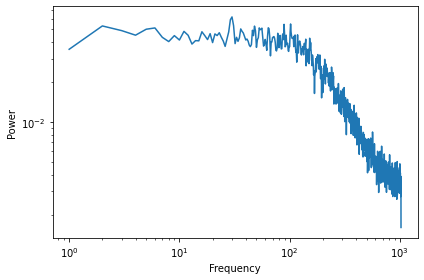

In [18]:
from scipy.signal import welch
from matplotlib import pyplot as plt
from src.utils import *

freqs, pows = welch(model.num_matches_by_step, nperseg=2048, fs=2048)
freqs, pows = freqs[freqs > 0], pows[freqs > 0]
plt.plot(freqs, pows)
decorate(xlabel='Frequency',
         xscale='log',
         ylabel='Power',
         yscale='log')
plt.show()

The line here is clearly not horizontal (a line with slope 0, AKA white noise), but the actual slope is unclear since the line is nonlinear. For a very basic analysis, I will calculate the slope of the "line" with all the data, and then ignoring anything less than 50 Hz, which is around the point where the curve goes from horizontal to sloped.

In [19]:
from scipy.stats import linregress

logfreq = np.log(freqs[freqs>0])
logpow = np.log(pows[freqs>0])

full_slope = linregress(logfreq, logpow)
cut_slope = linregress(logfreq[freqs > 50], logpow[freqs > 50])

full_slope.slope, cut_slope.slope

(-0.8148917602793525, -1.1258967728378235)

While there is clearly more going on here given the shape of the power spectrum, with either analysis, $\alpha$ is between 0 and 2, which shows the presence of pink noise.

### Long-Tailed Distributions

The most common type of long-tailed distribution is a power law - a distribution similar to that of pink noise, where the value of the Probability-Mass Function (PMF) is proportional to $\frac{1}{x^\beta}$. To find the value of $\beta$, I will use `empiricaldist`'s `Pmf` class (a glorified Pandas Dataframe), and give it the the data from `MatchingModel`. I will then plot each distribution on a linear scale to show long tails, then on a log-log scale to calculate $\beta$. If any of the distributions are linear on a log-log scale, then the system exhibits a power law and therefore long-tailed distributions.

In [20]:
try:
    import empiricaldist
except:
    !pip install empiricaldist

from empiricaldist import Pmf

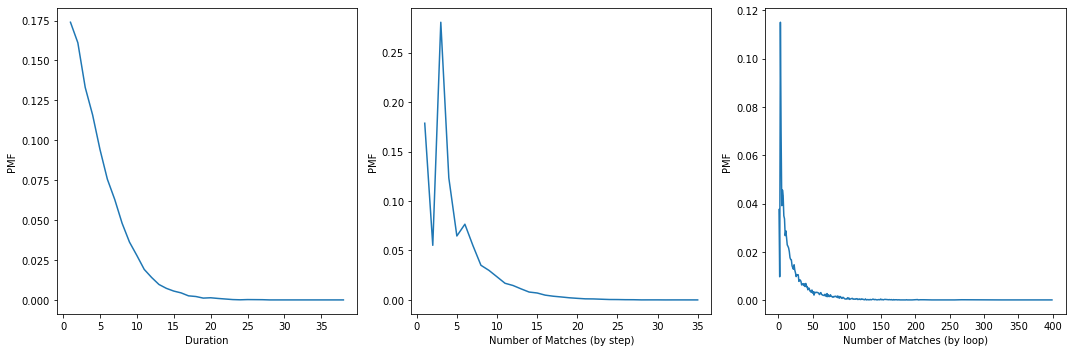

In [22]:
def plot_pmf(data, xlabel, log=False):
    D = np.array(data)
    D = D[D > 0]  # Filter out any steps that did nothing
    pmf = Pmf.from_seq(D)
    pmf.plot()
    if log:
        decorate(xlabel=xlabel, ylabel='PMF', xscale='log', yscale='log')
    else:
        decorate(xlabel=xlabel, ylabel='PMF')
    return pmf

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plot_pmf(model.duration, 'Duration')
plt.subplot(1, 3, 2)
plot_pmf(model.num_matches_by_step, 'Number of Matches (by step)')
plt.subplot(1, 3, 3)
plot_pmf(model.num_matches_by_loop, 'Number of Matches (by loop)')
plt.show()

Each of these distributions are clearly long-tailed (with the possible exception of matches by step). They each start large, and quickly decrease to 0 before roughly asymptoting there. Even if the following analysis fails to show a power law, matching games do have long-tailed distributions.

To analyze the possibility of a power law, I will plot the same PMFs on a log-log scale. If the PMF does follow a power law, the resulting graph will be roughly linear with a slope of $-\beta$.

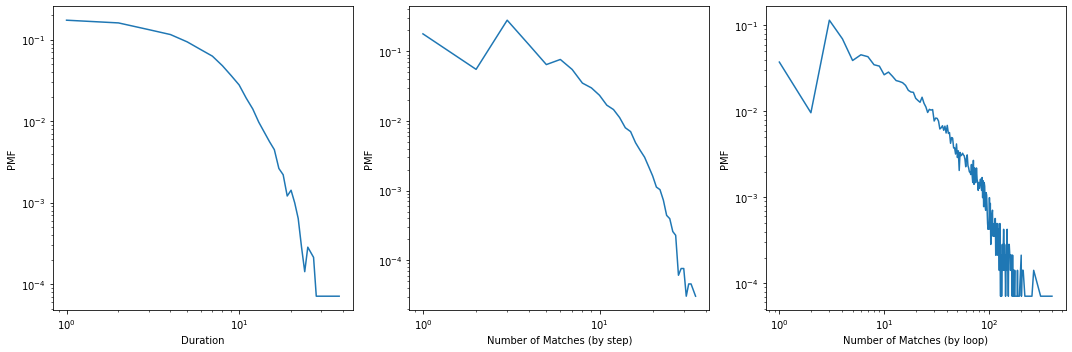

In [24]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
pmfT = plot_pmf(model.duration, 'Duration', True)
plt.subplot(1, 3, 2)
pmfM = plot_pmf(model.num_matches_by_step, 'Number of Matches (by step)', True)
plt.subplot(1, 3, 3)
pmfMl = plot_pmf(model.num_matches_by_loop, 'Number of Matches (by loop)', True)
plt.show()

The only distribution here that has a shot at being a power law is the number of matches by loop. The rest are clearly curved, and so linear analysis will not apply.

In [25]:
logx = np.log(np.arange(len(pmfMl)) + 1)
logy = np.log(pmfMl.values)

linreg = linregress(logx, logy)
linreg.slope

-1.8431533662717172

The $\beta$ will vary depending on the run, but I have been getting values between 1 and 2. Since the data on a log log scale is approximately linear, it likely follows a power law and is therefore a long-tailed distribution. Although both other sets of data are curved on a log-log scale, they are still long-tailed distributions, showing their presence in matching games.

### Fractals

The final step of showing SOC in a system is to show that the system has fractals. A fractal is an object with a fractional dimension - in this case, a dimension between 1 and 2. In 1 dimension, doubling the length will double the equivalent metric. In 2 dimensions, doubling the length will quadruple the equivalent metric. In a fractal between 1 and 2 dimensions, doubling the length will more than double the equivalent metric, but less than quadruple it. If this happens, then the object is a fractal.

The fractal dimension can be estimated with the box counting method. I will first need a binary grid - say, all the cells that contain a 0. To implement the box counting method, take a subsection of this binary grid with some size, and count the number of boxes (i.e. values where the color is 0). Repeat for a wide range of sizes. Plot this data on a log-log scale and calculate the slope. This slope is approximately the dimension - if it is significantly far from both 1 and 2, the object is likely a fractal.

Since this method is not reliable with 10 data points, I will create a grid of size 100. So that the pattern has sufficient time to set in, I will step through the swap-update loop 1,000 times From here, I can run the box-counting algorithm once for each color. Since the model does not care about color - it treats each color the same - the fractal dimension should be roughly equal for each of them. If the resulting dimension is far from both 1 and 2, then the grid has fractals.

In [96]:
model2 = MatchingModel(100, colors=4)
model2.setup()  # step is run in setup
controller2 = RandomController(model2)
for _ in range(1000):
    controller2.update()
    model2.step()

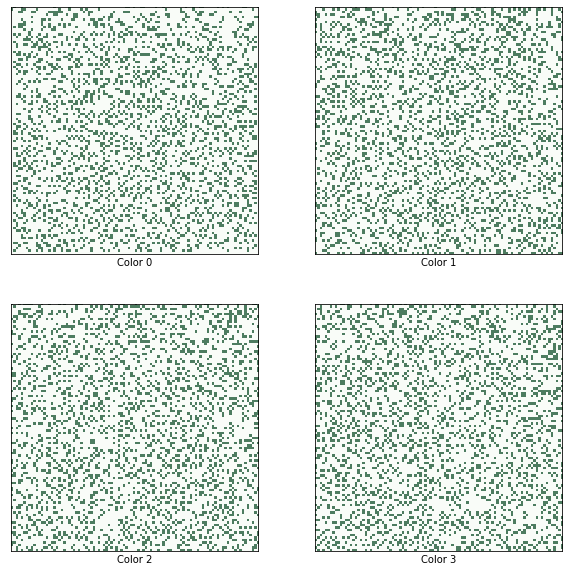

In [98]:
grids = tuple(model2.grid == i for i in range(4))

m, n = model2.grid.shape
options = dict(cmap='Greens',
                alpha=0.7,
                vmin=0, vmax=1,
                interpolation='none',
                origin='upper',
                extent=[0, m, 0, n])
plt.figure(figsize=(10, 10))
for i, grid in enumerate(grids):
    plt.subplot(2, 2, i+1)
    plt.imshow(grid, **options)
    plt.xlabel(f'Color {i}')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [99]:
def dimension_from_box_count(grid, plot=False):
    data = []
    for size in range(5, grid.shape[0] // 2):
        data.append((size, np.sum(grid[:size, :size])))
    xs, ys = np.transpose(data)
    nonzero = (xs > 0) & (ys > 0)
    xs, ys = xs[nonzero], ys[nonzero]
    logx, logy = np.log(xs), np.log(ys)
    if plot:
        plt.plot(xs, xs ** 2, linestyle='dashed', color='gray', label='2-D')
        plt.plot(xs, ys, label='Data')
        plt.plot(xs, xs, linestyle='dashed', color='gray', label='1-D')
        decorate(xlabel='Size', ylabel='Box Count', xscale='log', yscale='log')
    return linregress(logx, logy).slope

Color 0 has a dimension of 2.08411500808706
Color 1 has a dimension of 2.0190214633985843
Color 2 has a dimension of 1.8643340768895258
Color 3 has a dimension of 2.059769596242961


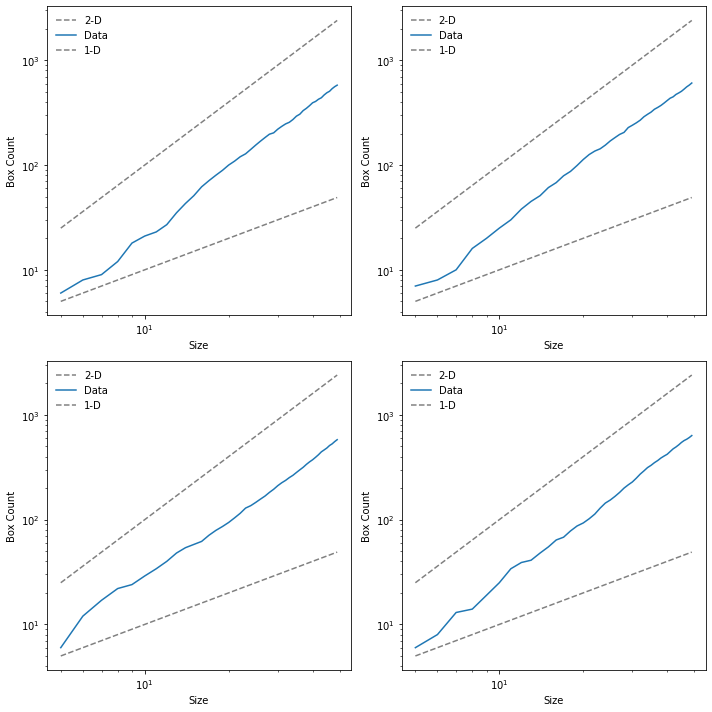

In [100]:
plt.figure(figsize=(10, 10))
for i, grid in enumerate(grids):
    plt.subplot(2, 2, i+1)
    print(f'Color {i} has a dimension of {dimension_from_box_count(grids[i], True)}')
plt.show()

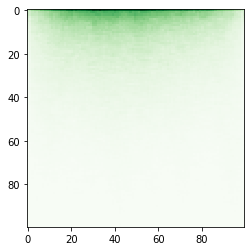

In [94]:
matches = np.zeros(model2.grid.shape)
model2.setup()

def update_matches(m):
    global matches
    matches = matches + m

for _ in range(1000):
    controller2.update()
    model2.loop_until_done(update_matches)

plt.imshow(matches, cmap='Greens', interpolation='none')
plt.show()

1.8715530632345

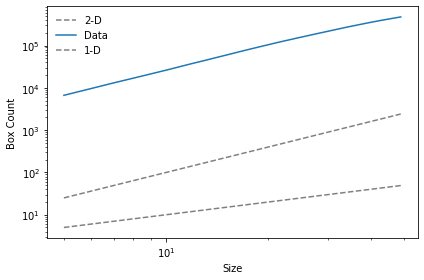

In [105]:
dimension_from_box_count(matches, True)

In [ ]:
all_matches = []

In [ ]:
for i in range(200):
    print(i)
    model2.setup()
    matches = np.zeros(model2.grid.shape)
    for _ in range(200):
        controller2.update()
        model2.loop_until_done(update_matches)
    all_matches.append(matches)

0
1


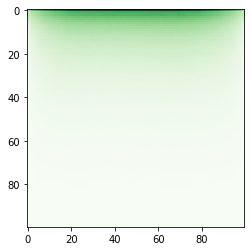

In [107]:
avmatch = sum(all_matches, start=np.zeros(model2.grid.shape)) / len(all_matches)
plt.imshow(avmatch, cmap='Greens', interpolation='none')
plt.show()

In [109]:
colmean = np.mean(avmatch, axis=1)
colmean

array([1.5204205e+02, 9.7147600e+01, 9.1344600e+01, 8.2418850e+01,
       7.5850700e+01, 6.9790250e+01, 6.4818800e+01, 6.0357800e+01,
       5.6421300e+01, 5.2951350e+01, 4.9922200e+01, 4.7077550e+01,
       4.4670850e+01, 4.2348000e+01, 4.0202250e+01, 3.8205800e+01,
       3.6347650e+01, 3.4694350e+01, 3.3261450e+01, 3.1704000e+01,
       3.0485550e+01, 2.9128000e+01, 2.7868450e+01, 2.6729450e+01,
       2.5619750e+01, 2.4449850e+01, 2.3509200e+01, 2.2510550e+01,
       2.1550050e+01, 2.0594550e+01, 1.9657800e+01, 1.8782450e+01,
       1.7978350e+01, 1.7160950e+01, 1.6340000e+01, 1.5640950e+01,
       1.4814750e+01, 1.4076000e+01, 1.3374650e+01, 1.2812300e+01,
       1.2140850e+01, 1.1554650e+01, 1.0956650e+01, 1.0504850e+01,
       9.9080000e+00, 9.4036000e+00, 8.8440000e+00, 8.3161500e+00,
       7.9214500e+00, 7.4639000e+00, 7.0860500e+00, 6.6879000e+00,
       6.3010000e+00, 5.8955500e+00, 5.5990500e+00, 5.2698500e+00,
       4.8484500e+00, 4.5706500e+00, 4.2569000e+00, 4.0075000e

In [111]:
for v in colmean:
    print(np.round(v, 4), end=',')

152.042,97.1476,91.3446,82.4189,75.8507,69.7902,64.8188,60.3578,56.4213,52.9513,49.9222,47.0776,44.6708,42.348,40.2022,38.2058,36.3476,34.6944,33.2615,31.704,30.4856,29.128,27.8684,26.7294,25.6198,24.4498,23.5092,22.5106,21.5501,20.5946,19.6578,18.7824,17.9784,17.1609,16.34,15.641,14.8147,14.076,13.3746,12.8123,12.1408,11.5546,10.9566,10.5049,9.908,9.4036,8.844,8.3161,7.9214,7.4639,7.086,6.6879,6.301,5.8956,5.5991,5.2699,4.8484,4.5707,4.2569,4.0075,3.7709,3.4637,3.2412,3.0093,2.792,2.5934,2.4064,2.1928,2.0033,1.8695,1.73,1.5899,1.4712,1.3237,1.1982,1.1016,1.0066,0.893,0.8267,0.713,0.645,0.5851,0.5342,0.4782,0.4122,0.3692,0.3396,0.2982,0.2583,0.2252,0.1802,0.1563,0.1433,0.1148,0.1042,0.0937,0.0782,0.0629,0.0484,0.0463,

In [112]:
rowmean = np.mean(avmatch, axis=0)
rowmean

array([ 6.1244 ,  7.4631 , 10.55585, 11.51175, 12.51945, 13.37025,
       14.15565, 14.81425, 15.49925, 16.0856 , 16.5837 , 17.0053 ,
       17.45255, 17.7889 , 18.13095, 18.3847 , 18.64315, 18.9061 ,
       19.10325, 19.28855, 19.37975, 19.52895, 19.66245, 19.6828 ,
       19.76315, 19.8123 , 19.7877 , 19.81635, 19.79805, 19.822  ,
       19.79205, 19.7543 , 19.73265, 19.8137 , 19.76935, 19.78685,
       19.8085 , 19.83505, 19.844  , 19.8834 , 19.94665, 19.96135,
       20.0442 , 20.07985, 20.09525, 20.17935, 20.16525, 20.13745,
       20.12565, 20.2145 , 20.29325, 20.3181 , 20.4187 , 20.57695,
       20.5832 , 20.63145, 20.65515, 20.65115, 20.6192 , 20.64055,
       20.74705, 20.84455, 20.92295, 20.88685, 20.92855, 20.90635,
       20.91355, 20.81245, 20.80235, 20.8404 , 20.6278 , 20.5314 ,
       20.38085, 20.29845, 20.1717 , 20.0565 , 19.87555, 19.66615,
       19.44095, 19.289  , 19.0758 , 18.80045, 18.57855, 18.1997 ,
       18.0503 , 17.7051 , 17.38865, 16.99665, 16.70125, 16.13

In [114]:
for v in rowmean:
    print(np.round(v, 4), end=',')

6.1244,7.4631,10.5559,11.5117,12.5194,13.3703,14.1557,14.8142,15.4992,16.0856,16.5837,17.0053,17.4526,17.7889,18.131,18.3847,18.6432,18.9061,19.1033,19.2885,19.3798,19.529,19.6624,19.6828,19.7632,19.8123,19.7877,19.8163,19.798,19.822,19.792,19.7543,19.7326,19.8137,19.7693,19.7868,19.8085,19.8351,19.844,19.8834,19.9466,19.9614,20.0442,20.0798,20.0952,20.1793,20.1652,20.1374,20.1256,20.2145,20.2932,20.3181,20.4187,20.577,20.5832,20.6314,20.6551,20.6512,20.6192,20.6406,20.747,20.8446,20.9229,20.8868,20.9286,20.9063,20.9135,20.8124,20.8023,20.8404,20.6278,20.5314,20.3808,20.2985,20.1717,20.0565,19.8755,19.6661,19.4409,19.289,19.0758,18.8004,18.5786,18.1997,18.0503,17.7051,17.3887,16.9967,16.7013,16.137,15.6209,15.1114,14.5489,13.8461,13.1017,12.2315,11.2351,10.2445,7.286,5.968,